# PROBLEM SET-1: BAYESIAN DECISION THEORY

In [1]:
from mnist import MNIST
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
mnist = MNIST('./dataset')

In [2]:
#Load training and testing data from the dataset
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

#assign training images to X_train and training labels to y_train
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)

#assign testing images to X_test and testing labels to y_test
x_test = np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

In [3]:
#Dividing the X_train dataset into 10 classes, from 0-9
num_arr = np.asarray([np.asarray(x_train[y_train==x]) for x in range(10)])

#Finding the mean digit for each of the digits in num_dict
mean_digits = np.asarray([np.mean(num_arr[x], axis=0) for x in range(10)])

#Finding the standard deviation digit for each of the digits in num_dict
standard_deviation_digits = np.asarray([np.std(num_arr[x], axis=0) for x in range(10)])

## PART 1: Displaying mean and standard deviation digits

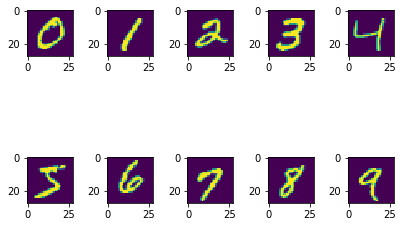

In [4]:
fig, ax = plt.subplots(2, 5)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.75,wspace=0.75)
for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(num_arr[i][0], (28,28))
    ax.imshow(plottable_image)

### Mean Digits

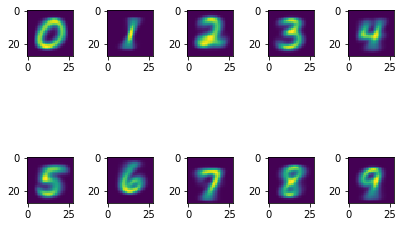

In [5]:
fig, ax = plt.subplots(2, 5)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.75,wspace=0.75)
for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(mean_digits[i], (28,28))
    ax.imshow(plottable_image)

### Standard Deviation Digits

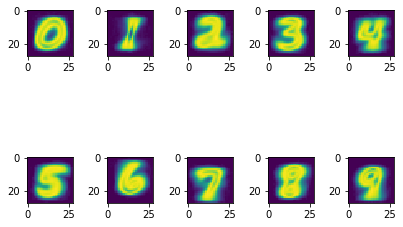

In [6]:
fig, ax = plt.subplots(2, 5)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.10, right=0.95, hspace=0.75,wspace=0.75)
for i, ax in enumerate(ax.flatten()):
    plottable_image = np.reshape(standard_deviation_digits[i], (28,28))
    ax.imshow(plottable_image)

## Part 2: Image classification using Bayesian Decision Theory

Let {$w_{1}....w_{c}$} be a finite set of c state of nature(0-9 class of numbers in this case) and {$x_{1}...x_{d}$} be a set of feature vectors (the pixel values of the 28 X 28 images)

Bayes Rule is given as,

## $P(w_{j}|x) = \frac{p(x| w_{j})P(w_{j})}{p(x)}$ 

where,


 $P(w_{j}|x)$ = Posterior probability  of the class being $w_{j}$ given feature x,
     
 $p(x| w_{j})$ = class conditional probability of x given class $w_{j}$ or likelihood,
     
 $P(w_{j})$ = Prior probability or state of nature,
     
 p(x) = evidence
 
 
or,

## $Prior = \frac{Likelihood X Prior}{Evidence}$

In [7]:
#Finding the prior probability (state of nature, w)
P_w = [np.round(num_arr[x].shape[0]/x_train.shape[0],3) for x in range(10)]
           
#Covariance matrix for each of the digits from 0-1
cov = [np.cov(num_arr[x], rowvar=False) for x in range(10)]

#Addng a small noise to the diagonal of the covariance matrix to avoid singularity error when finding inverse
covariance_matrix = [cov[x] + 0.5*np.identity(cov[x].shape[0]) for x in range(10)]

#inverse of covariance matrix
cov_inv = [np.linalg.inv(covariance_matrix[x]) for x in range(10)]

#log of determinant of covariance matrix. The function slogdet returns a 2-element tuple containing the sign 
#and the log of the determinant of the covariance matrix
cov_log_det = [np.linalg.slogdet(covariance_matrix[x])[1] for x in range(10)]


## Discriminant function

Assuming that the features x have a normal distribution ~ N($\mu, \sigma^{2}$), the multivariate normal density in 'd' dimensions is written as,

## $p(x) = \frac{1}{(2\pi)^{d/2}|\Sigma|^{1/2}}exp[-\frac{1}{2}(x-\mu)^{t}\Sigma^{-1}(x-\mu)]$

where,

x is a d-component vector,

$\mu$ is the d-component mean vector,

$\Sigma$ is the d-by-d covariance matrix,

|$\Sigma$| and $\Sigma^{-1}$ are its determinant and inverse,


$(x-\mu)^{t}$ is the transpose of $(x-\mu)$


For minimum error-rate classification, we use the following discriminant function,

###  $g_{i}$(x) =  ln p(x|$w_{i}$) + ln $P(w_{i})$

where i represents the class (0-9)

This expression can be evaluated as follows since the densities $p(x|w_{i}) $ are multivariate normal,

### $g_{i}(x) = -\frac{1}{2}(x-\mu_{i})^{t}\Sigma_{i}^{-1}(x-\mu_{i}) - \frac{d}{2}ln  2 \pi - \frac{1}{2}ln |\Sigma_{i}| + ln P(w_{i})$

### Generic Linear Discriminant Function

In [8]:
def linear_discriminant_function(x, n):
    likelihood_term1 = -0.5 * np.dot(np.dot((x-mean_digits[n]), cov_inv[n]), (x-mean_digits[n]).T)
    likelihood_term2 = -0.5 * x.shape[0]*np.log(2*np.pi)
    likelihood_term3 = -0.5 * cov_log_det[n]
    log_prior = np.log(P_w[n])
    return likelihood_term1+likelihood_term2+likelihood_term3+log_prior

    
linear_loss = 0
for i in range(y_test.shape[0]):
    linear_pred_values = [linear_discriminant_function(x_test[i],n) for n in range(10)]
    linear_pred = np.argmax(linear_pred_values)
    if linear_pred!=y_test[i]:
        linear_loss += 1

### 0-1 Loss

We use 0-1 loss to evaluate the performance of our predictor. If the predicted class matches the true class for the test data we assign a loss of 0, else a loss of 1. We then use the cumulative loss to determine the accuracy of our classifier.

In [9]:
linear_accuracy = (y_test.shape[0] - linear_loss)/y_test.shape[0]
print("Linear discriminant function: Loss = {0}/{1}".format(linear_loss, y_test.shape[0]))
print("Linear discriminant function: Accuracy", linear_accuracy)

Linear discriminant function: Loss = 1690/10000
Linear discriminant function: Accuracy 0.831


### Quadratic Discriminant Function
We see that that covariance matrices are different for each category and our features are multivariate normal. Hence our discriminant functions are inherently quadratic:

## $g_{t}(x) = x^{t}W_{i}x + w^{t}_{i}x + \omega_{i0}$

where, 

#### $W_{i} = -\frac{1}{2}\Sigma_{i}^{-1}$

#### $w_{i} = \Sigma_{i}^{-1}\mu_{i}$

and 

#### $ \omega_{i0} = -\frac{1}{2}\mu_{i}^{t}\Sigma_{i}^{-1}\mu_{i} - \frac{1}{2}ln |\Sigma_{i}| + ln P(w_{i})$

In [10]:
def quadratic_discriminant_function(x, n):
    W_i = -0.5*cov_inv[n]
    W_i_x = np.dot(np.dot(x.T, W_i), x)
    N_i = np.dot(cov_inv[n], mean_digits[n])
    N_i_x = np.dot(N_i.T, x)
    B_i_0 = -0.5*(np.dot(np.dot(mean_digits[n].T,cov_inv[n]), mean_digits[n])) + np.log(P_w[n]) - (0.5*cov_log_det[n])
    discriminant = W_i_x + N_i_x + B_i_0
    return discriminant


quadratic_loss = 0
for i in range(y_test.shape[0]):
    quad_pred_values = [quadratic_discriminant_function(x_test[i],n) for n in range(10)]
    quadratic_pred = np.argmax(quad_pred_values)
    if quadratic_pred!=y_test[i]:
        quadratic_loss += 1

In [11]:
quadratic_accuracy = (y_test.shape[0] - quadratic_loss)/y_test.shape[0]
print("Quadratic discriminant function: Loss = {0}/{1}".format(quadratic_loss, y_test.shape[0]))
print("Quadratic discriminant function: Accuracy", quadratic_accuracy)

Quadratic discriminant function: Loss = 1690/10000
Quadratic discriminant function: Accuracy 0.831


## Comparison with other Classifiers found on Yann Lecun's website

As seen above, the LDA and QDA methods we used to estimate perform fairly well, giving an accuracy of above 80%. However, in comparison to the other methods mentioned in Yann Lecun's website, LDA and QDA have a lower performance. The main problem with these methods is that the conditional densities $p(x|w_{j})$ of the features are not known. We only assume that these densities are multivariate normal. Apart from this, we also assume that the mean vector of the  features contains majority of the characterstics of the underlying model which may or may not be true. Other methods use the training data to modify and reach an estimation of the model that behaves closest to the underlying distribution and hence provide better results.